### Title: 
#### Predict Costa Rican Household Poverty Level

### Group Members:
- Cheah Jun Yitt (WQD180107)
- Choong En Jun (WQD180113)
- Choo Jian Wei (WQD180124)
- Tan Yin Yen (WQD180108)

### Overview:
Many social programs have a hard time making sure the right people are given enough aid. It’s especially tricky when a program focuses on the poorest segment of the population. The world’s poorest typically can’t provide the necessary income and expense records to prove that they qualify.   
In Latin America, one popular method uses an algorithm to verify income qualification. It’s called the Proxy Means Test (or PMT). With PMT, agencies use a model that considers a family’s observable household attributes like the material of their walls and ceiling, or the assets found in the home to classify them and predict their level of need.

<https://www.kaggle.com/c/costa-rican-household-poverty-prediction>

### Data:
<https://www.kaggle.com/c/costa-rican-household-poverty-prediction/data>


### Table of Content
1) Package Installation 
2) Reading Data
3) Dealing with Outliers
4) Dealing with Missing Data


- Visualization
- Modelling
- Model Evaluation
- Conclusion

### Installation of lightgbm package

In [1]:
# !pip install lightgbm

### Load python packages

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"
pd.options.display.max_columns = 150

#for machine learning
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
import lightgbm as lgb


### Read Data

In [2]:
train = pd.read_csv('../data/train.csv')
train.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(130), object(5)
memory usage: 10.4+ MB


,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,1,1,0,0,0,0,1,1,1,1,10,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,21eb7fcc1,0,1,0,1,no,10,no,10.0,0,0,0,1,0,0,0,0,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,43,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,1,1,12,NaN,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0e5d7a658,0,1,1,1,8,12,no,12.0,0,0,0,0,0,0,0,1,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,67,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,0,0,0,1,1,0,1,1,1,1,11,NaN,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2c7317ea8,0,1,1,1,8,no,11,11.0,0,0,0,0,1,0,0,0,0,2,0.500000,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,92,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,9,1.0,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,yes,11,no,11.0,0,0,0,1,0,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,17,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,11,NaN,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,yes,11,no,11.0,0,0,0,0,1,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,37,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [3]:
test = pd.read_csv('../data/test.csv')
test.info()
test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23856 entries, 0 to 23855
Columns: 142 entries, Id to agesq
dtypes: float64(8), int64(129), object(5)
memory usage: 25.8+ MB


,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq
0,ID_2f6873615,NaN,0,5,0,1,1,0,NaN,1,1,2,0,1,1,1,2,3,3,3,0,NaN,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,72958b30c,1,2,0,3,.5,no,17,16.5,1,0,0,0,0,0,0,0,0,2,1.5,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,4,0,16,9,0,1,2.25,0.25,272.25,16
1,ID_1c78846d2,NaN,0,5,0,1,1,0,NaN,1,1,2,0,1,1,1,2,3,3,3,16,NaN,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,72958b30c,1,2,0,3,.5,no,17,16.5,0,0,0,0,0,0,0,1,0,2,1.5,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,41,256,1681,9,0,1,2.25,0.25,272.25,1681
2,ID_e5442cf6a,NaN,0,5,0,1,1,0,NaN,1,1,2,0,1,1,1,2,3,3,3,17,NaN,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,72958b30c,1,2,0,3,.5,no,17,16.5,0,0,0,0,0,0,0,0,1,2,1.5,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,41,289,1681,9,0,1,2.25,0.25,272.25,1681
3,ID_a8db26a79,NaN,0,14,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,1,1,16,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5b598fbc9,0,1,0,1,no,16,no,16.0,0,0,0,0,0,0,0,1,0,1,1.0,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,59,256,3481,1,256,0,1.00,0.00,256.00,3481
4,ID_a62966799,175000.0,0,4,0,1,1,1,1.0,0,0,0,0,1,1,0,1,1,1,1,11,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1e2fc704e,1,0,0,1,8,no,11,NaN,0,0,0,0,1,0,0,0,0,2,0.5,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,18,121,324,1,0,1,0.25,64.00,NaN,324


**Train data have 9557 entries, Test data have 23855 entries. Lets take a look at the statistic of the attributes.**

In [8]:
train.describe()
test.describe()


,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,hogar_nin,hogar_adul,hogar_mayor,hogar_total,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq
count,6.453000e+03,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,5730.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,4203.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.00000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23825.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.00000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23825.000000,23856.000000
mean,1.748726e+05,0.050679,4.955776,0.028421,0.992748,0.961603,0.240191,1.348517,0.416541,1.563967,1.980508,0.389168,1.656522,2.045691,0.805709,3.220490,4.026199,4.021756,4.140426,7.214914,0.402808,4.021756,0.588741,0.077171,0.201375,0.008300,0.107017,0.014462,0.001677,0.001258,0.692740,0.234029,0.001761,0.000126,0.013456,0.057889,0.971538,0.018989,0.002138,0.001425,0.669559,0.962274,0.032487,0.005240,0.879527,0.000503,0.003856,0.114940,0.003647,0.225394,0.753060,0.016055,0.001844,0.002222,0.476861,0.476903,0.044014,0.875419,0.034708,0.086058,0.001677,0.000168,0.001970,0.111460,0.322938,0.565602,0.127222,0.307596,0.565183,0.102490,0.270540,0.62697,0.056757,0.490401,0.509599,0.137827,0.123198,0.273265,0.035924,0.058811,0.033409,0.337567,0.307428,0.187500,0.384809,0.013665,0.008426,0.049212,0.009809,0.003228,0.012617,0.002767,0.012701,0.007839,1.412559,2.609197,0.295146,4.0

## Dealing with Outliers
**If we look carefully, There is an outlier for attribute rez_esc in test data.**

In [9]:
print(test.loc[:,"rez_esc"].describe())
test.loc[test.loc[:,"rez_esc"]==99,"rez_esc"]

count    4203.000000
mean        0.402808
std         0.903882
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         5.000000
Name: rez_esc, dtype: float64


Series([], Name: rez_esc, dtype: float64)

We can see that there is only one outlier =99, the rest of the test data is okay.  
According to answer from kaggle competition host, the value can be safely changed to 5.  
<https://www.kaggle.com/c/costa-rican-household-poverty-prediction/discussion/61403>

In [10]:
test.loc[test.loc[:,"rez_esc"]==99,"rez_esc"]=5
test.loc[:,"rez_esc"].describe()

count    4203.000000
mean        0.402808
std         0.903882
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         5.000000
Name: rez_esc, dtype: float64

## Dealing with Missing Data
**Now we will deal with missing values in both test and train dataset.**  
- We will first check for missing values in the columns

In [11]:
train_na= pd.DataFrame((train.isnull().sum().values),index=train.columns, columns=['isNA']).sort_values(by=['isNA'],ascending=False)
if train_na.loc[train_na.loc[:,'isNA']>0,:].shape[0]>1 :
    train_na.loc[train_na.loc[:,'isNA']> 0,]
else:
    print('no NA in train set')

test_na= pd.DataFrame((test.isnull().sum().values),index=test.columns, columns=['isNA']).sort_values(by=['isNA'],ascending=False)
if train_na.loc[train_na.loc[:,'isNA']>0,:].shape[0]>1 :
    test_na.loc[test_na.loc[:,'isNA']> 0,]
else:
    print('no NA in test set')

**We can see the missing values are largely from:**

- ***rez_esc: years behind in school:***

- ***v18q1: number of tablets household owns***

- ***v2a1: monthly rent payment***

- ***meaneduc: average years of education for adults***

- ***SQBmeaned is the square of meaneduc***


For the variable ***rez_esc (years behind in school)***,  
data is only available if the age of individual is between 7 to 17 years old.  
We will set 0 to all other null values.

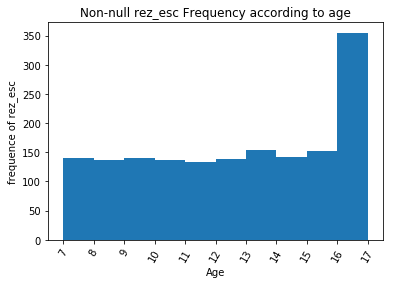

In [12]:
rez_esc_age=train.loc[train['rez_esc'].isnull()==False, 'age']

plt.hist(x=rez_esc_age,)
plt.xticks(np.arange(min(rez_esc_age), max(rez_esc_age)+1, 1.0),rotation = 60),
plt.ylabel('frequence of rez_esc')
plt.xlabel('Age')
plt.title('Non-null rez_esc Frequency according to age')
plt.show()

***v2a1: monthly rent payment***
    
-    this depends on tipovivi2 and tipovivi3, v2a1 is NA if tipovivi2 or tipovivi3 is 0
    tipovivi2 (a true false statement if an individual owns the house and is paying installment). 
    tipovivi3 (a true false statement if an individual is renting the house). 
    We will assume 0 for NA in v2a1

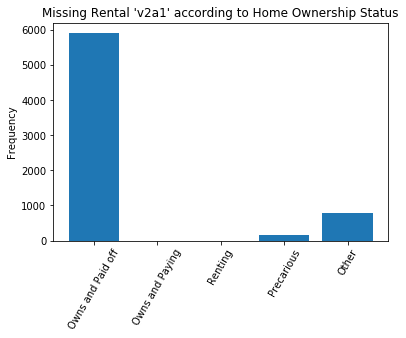

In [15]:
tipos=[x for x in train if x.startswith('tipo')]
rentNA_status=train.loc[train['v2a1'].isnull(), tipos].sum()
plt.bar(tipos,rentNA_status,align='center')
plt.xticks([0,1,2,3,4],['Owns and Paid off','Owns and Paying', 'Renting','Precarious','Other'],rotation = 60),
plt.ylabel('Frequency')
plt.title("Missing Rental 'v2a1' according to Home Ownership Status")
plt.show()

***v18q1: number of tablets household owns***

  -  This depends on v18q (a true false statement if an individual own a tablet). v18q1 is NA if v18q is 0
    We will assume 0 for NA in v18q1

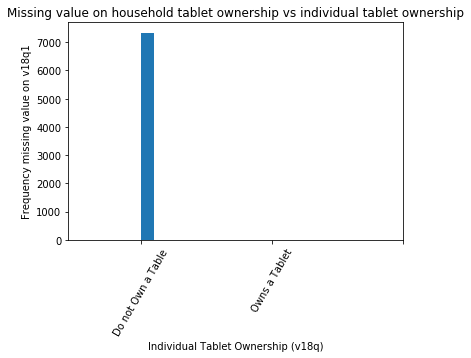

In [16]:
Tablet_status=train.loc[train['v18q1'].isnull(), 'v18q']
plt.hist(x=Tablet_status)
plt.xticks([0,1,2],['Do not Own a Table','Owns a Tablet'],rotation=60),
plt.ylabel('Frequency missing value on v18q1')
plt.xlabel('Individual Tablet Ownership (v18q)')
plt.title('Missing value on household tablet ownership vs individual tablet ownership')
plt.show()

***meaneduc: average years of education for adults***
  -  We will replace this with mode
    
***SQBmeaned is the square of meaneduc***
  - replace with square of replaced meaneduc

In [17]:
train["meaneduc"].isna().any()

True

C:\Users\jy\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\jy\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


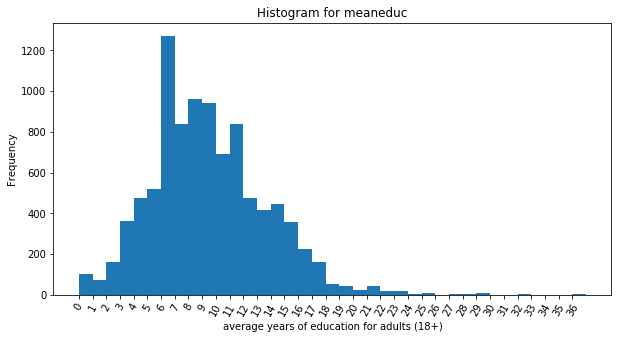

In [18]:
try: 
    plt.figure(figsize=(10,5))
    plt.hist(x=train['meaneduc'],bins=int(train['meaneduc'].max()))
    plt.xticks(np.arange(min(train['meaneduc']), max(train['meaneduc'])),rotation=60),
    plt.ylabel('Frequency')
    plt.xlabel('average years of education for adults (18+)')
    plt.title('Histogram for meaneduc')
    plt.show()
    
except:
    print("meaneduc contains NA.")


# Impute Missing Values
1. Impute ***meaneduc*** with mode (mode = 6)
2. Impute ***SQBmeaned*** with squared of mode of ***meaneduc*** (mode = 36)
3. Impute ***rez_esc***, ***v18q1*** and ***v2a1*** with 0 

In [19]:
train.loc[:,"meaneduc"].mode()
#train: mode for meaneduc is 6 replace NA with 6, replace SQBmeaned NA to 36
train.loc[train.loc[:,"meaneduc"].isnull()==True,"meaneduc"] = 6
train.loc[train.loc[:,"SQBmeaned"].isnull()==True,"SQBmeaned"] = 36

test.loc[:,"meaneduc"].mode()
#test: mode for meaneduc is 6 replace NA with 6, replace SQBmeaned NA to 36
test.loc[test.loc[:,"meaneduc"].isnull()==True,"meaneduc"] = 6
test.loc[test.loc[:,"SQBmeaned"].isnull()==True,"SQBmeaned"] = 36


#Replace all NA values for remaining 3 attributes with 0no
train.loc[train.loc[:,"rez_esc"].isnull()==True,"rez_esc"] = 0
train.loc[train.loc[:,"v18q1"].isnull()==True,"v18q1"] = 0
train.loc[train.loc[:,"v2a1"].isnull()==True,"v2a1"] = 0

test.loc[test.loc[:,"rez_esc"].isnull()==True,"rez_esc"] = 0
test.loc[test.loc[:,"v18q1"].isnull()==True,"v18q1"] = 0
test.loc[test.loc[:,"v2a1"].isnull()==True,"v2a1"] = 0


## Check for Missing Values

In [20]:
#Check for missing values again:
train_na= pd.DataFrame((train.isnull().sum().values),index=train.columns, columns=['isNA']).sort_values(by=['isNA'],ascending=False)
if train_na.loc[train_na.loc[:,'isNA']>0,:].shape[0]>1 :
    train_na.loc[train_na.loc[:,'isNA']> 0,]

else:
    print('No NA in train set')

test_na= pd.DataFrame((test.isnull().sum().values),index=test.columns, columns=['isNA']).sort_values(by=['isNA'],ascending=False)
if train_na.loc[train_na.loc[:,'isNA']>0,:].shape[0]>1 :
    test_na.loc[test_na.loc[:,'isNA']> 0,]
else:
    print('No NA in test set')

No NA in train set
No NA in test set


### Investigate if all individuals in the household have the same poverty target

In [21]:
target_Discrepancy=(train.groupby('idhogar')['Target'].nunique()>1)
num_unique_households = train["idhogar"].unique().shape[0]
print('There are',target_Discrepancy.sum(),'households with contradicting targets, out of', num_unique_households, 'households in the train dataset.')

There are 85 households with contradicting targets, out of 2988 households in the train dataset.


**Lets see the data for 85 households that have discrepancy in target poverty level**

In [22]:
Discrepancy_Index=(train.groupby('idhogar')['Target'].transform('nunique')>1)
HHID_Discrepancy=train.loc[Discrepancy_Index,'idhogar'].unique()
#household with contradicting target
train.loc[train['idhogar'].isin(HHID_Discrepancy),['idhogar','parentesco1','Target']].head()

,idhogar,parentesco1,Target
282,4b6077882,1,1
283,4b6077882,0,2
284,4b6077882,0,2
285,6833ac5dc,0,2
286,6833ac5dc,0,2


**Judging from the data, the household head target might not be necessary true. Although prediction scoring is based on household head target, we should be able to safely replace the household target using the mode target of the household.**


In [23]:

for HH in HHID_Discrepancy:
    Targets= (train.loc[train['idhogar']==HH,'Target'])

    if Targets.mode().shape[0] >1:
        for i in Targets.index:
            if train.loc[i,'parentesco1']==1:
                HeadTarget= train.loc[i,"Target"]    
        for i in Targets.index:
            train.loc[i,'Target']=HeadTarget
    elif Targets.mode().shape[0]==1:
        for i in Targets.index:
            TrueTarget=int(Targets.mode())
            train.loc[i,'Target']=TrueTarget
        


**Check for household targets discrepancy again for confirmation**

In [24]:
target_Discrepancy=(train.groupby('idhogar')['Target'].nunique()>1)

print('There are ',target_Discrepancy.sum(),'households with contradicting targets, out of 2988 households in the train dataset')

train.head()
train.shape

There are  0 households with contradicting targets, out of 2988 households in the train dataset


(9557, 143)

**Remove (SQBescolari, SQBage, SQBHogar_ttal,SQBedjefe, SQBhogar_nin,SQBovercrowding, SQBdependency, SQBMeaned, agesq)**  
There are 9 columns where the attributes are the squared of other attributes. We do not need those in our model as the model are smart enough to detect non-linear relationship.



In [25]:
train=train.drop(columns=train.columns[133:142],axis=1)
test=test.drop(columns=test.columns[133:142],axis=1)

In [26]:
print(train.shape)
print(test.shape)

(9557, 134)
(23856, 133)


# Visualization

## Household Level Features Visualization

**We Can Segregate the attributes into different categories**<br>
1st is by Household level or Individual level<br>
2nd is by Numerical or Categorical True/False<br>

So we will have 4 types of data<br>
-Household Numerical<br>
-Individual Numerical<br>
-Household Categorical<br>
-Individual Categorical<br>

For simple EDA, we will only look at training dataset, and plot a box plot on the numerical household variables.

In [27]:
#These are Household Numerical columns. Attribute "Dependency" is not included since it has some yes and no elements
catColumnsHH= ["v2a1","rooms","v18q1","qmobilephone","r4h3","r4m3","r4t3","tamhog","hhsize","hogar_nin","hogar_adul",
               "hogar_mayor","hogar_total","meaneduc","bedrooms","overcrowding"]

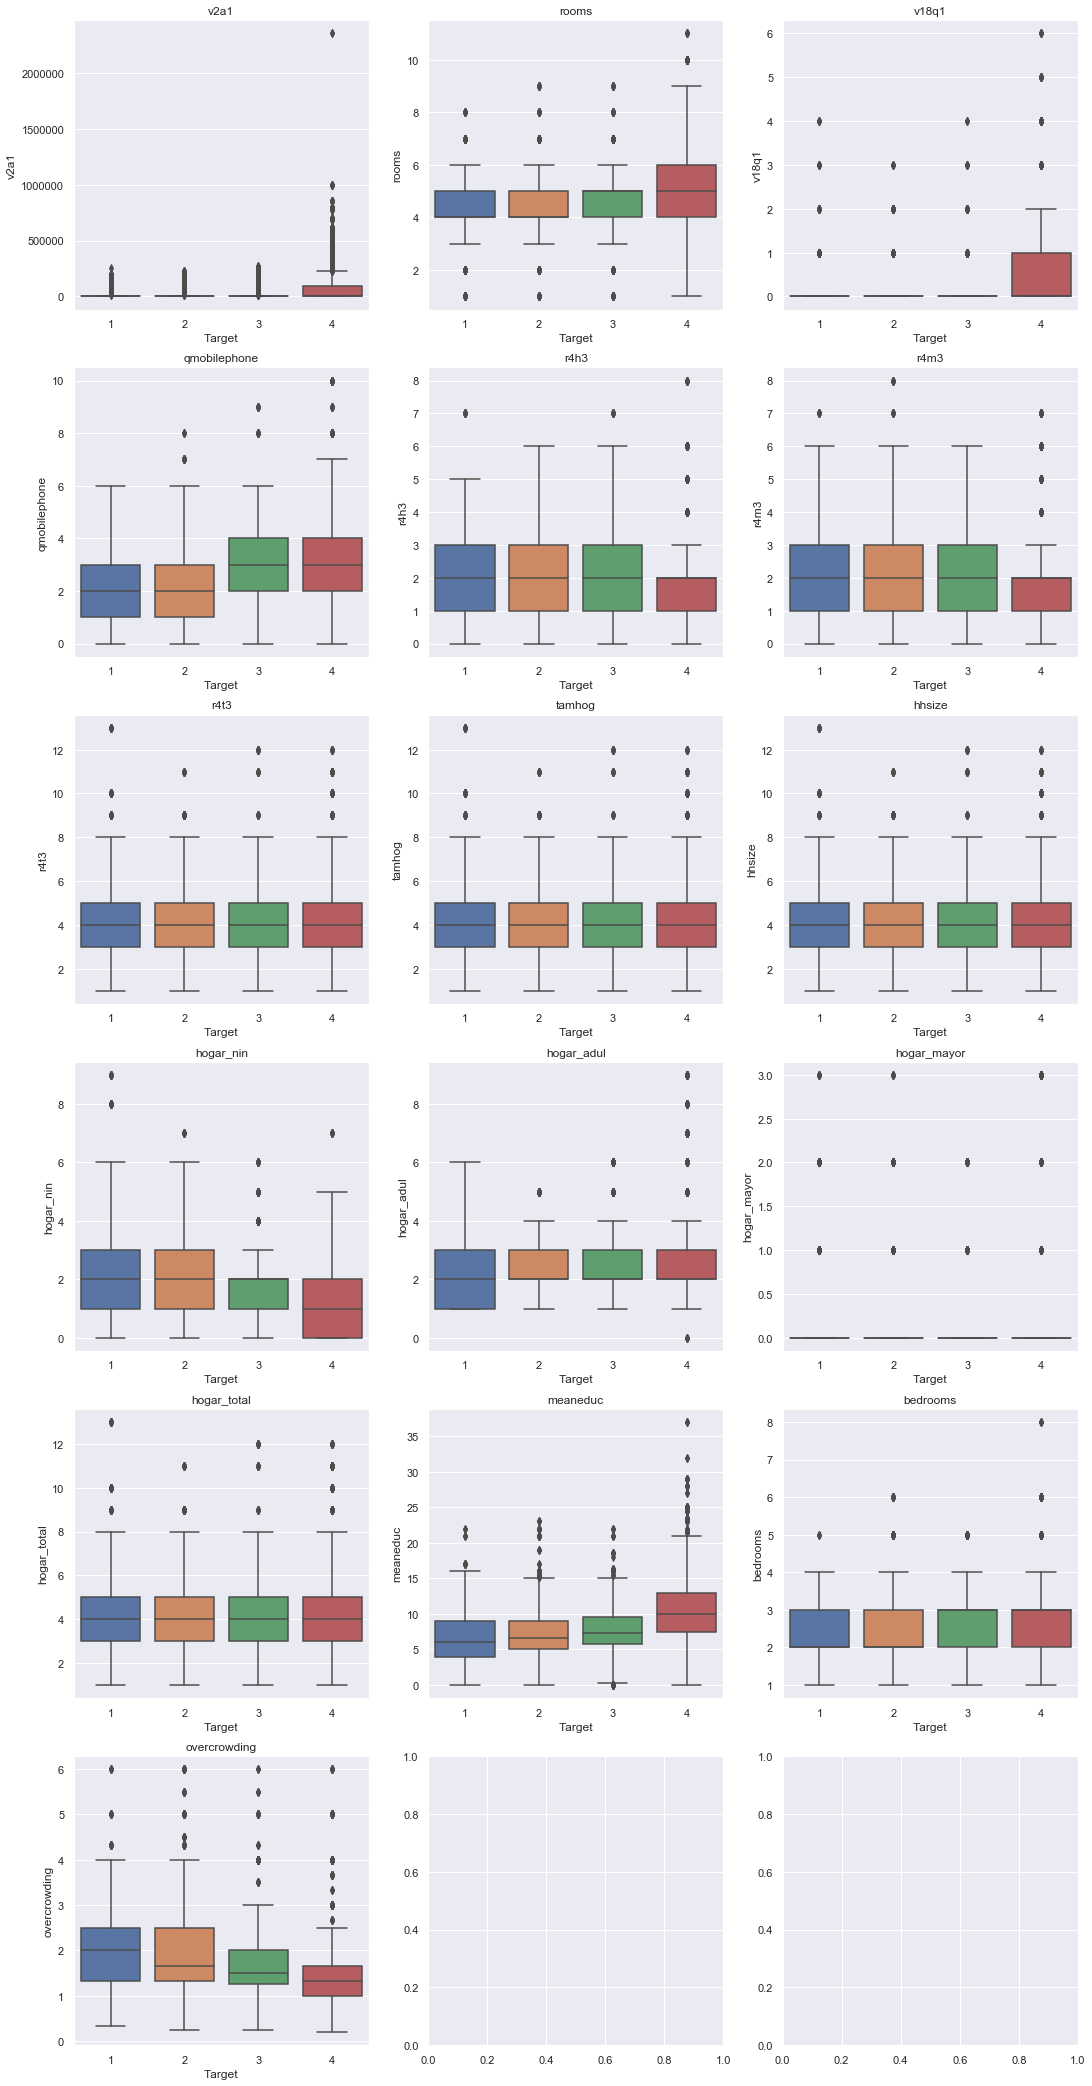

In [126]:
fig, ax =plt.subplots(6,3, figsize=(18,15))
plt.subplots_adjust(top=2.0)
x=0
y=0
for i in range(0,len(catColumnsHH)):
    if (i>0) & (i %3==0):
        x=x+1
        y=0
    sns.boxplot(x="Target",y=catColumnsHH[i], data=train, ax=ax[x,y])
    ax[x,y].title.set_text(catColumnsHH[i])
    y=y+1


**At one glance the box plot is useful compare the 4 targets' summary statistic of each variables plotted.**  
So far, the box plot make sense as we look at the slight difference in the variable mean between targets.  
1) number of mobile phone per househould - mean is lower in poverty level 1 and 2 indicating less affordability  
2) number of children "hogar_nin" - mean is lower in poverty level 3 & 4 indicating less commitment  
3) number of adults "hogar_adul" - mean is lower in poverty level 1 meaning less earning power  
4) mean education "mean educ: - mean has a upwarding bias from poverty level 1 to 4  
5) overcrowding - mean has a decreasing bias from poverty level 1 to 4  

Interestingly though, the box plot show a higher mean for total male and lower mean for total female in the poverty level 4, non-vulnerable group.  

## Visualize Living Conditions by Poverty Level

**For this section, we use data points for head of household only. We want to avoid having frequencies that were inflated by the number of individuals in a house.**

In [63]:
cond_data = train.query("parentesco1==1").copy()
cond_data.shape

(2973, 134)


### Visualize Various Household Conditions related Attributes by Poverty Level

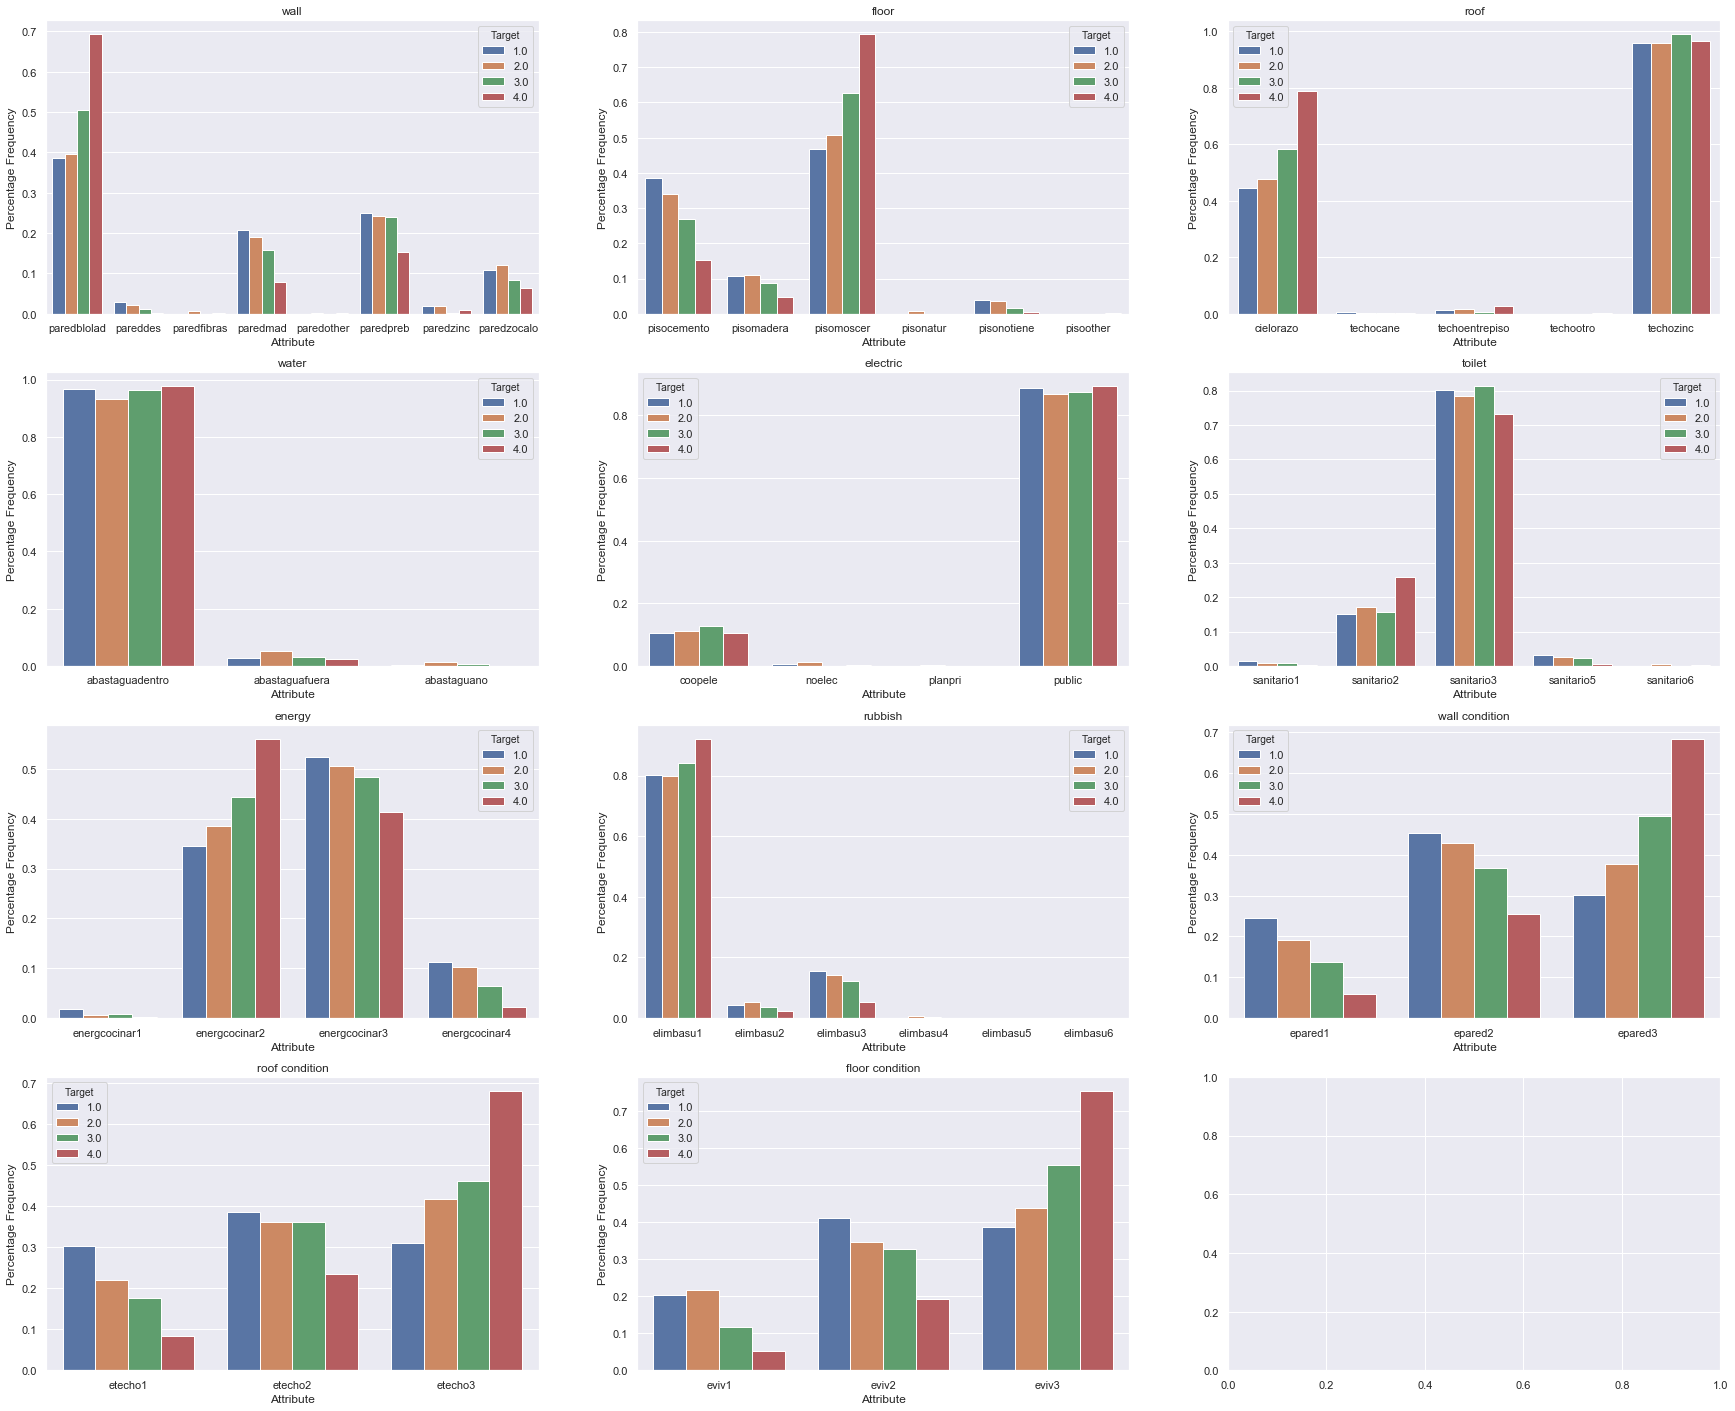

In [198]:
wall = ["paredblolad","paredzocalo","paredpreb","pareddes","paredmad","paredzinc","paredfibras","paredother"]
floor = ["pisomoscer","pisocemento","pisoother","pisonatur","pisonotiene","pisomadera"]
roof = ['techozinc','techoentrepiso','techocane','techootro', 'cielorazo']
water = ["abastaguadentro","abastaguafuera","abastaguano"]
electric = ["public","planpri","noelec","coopele"]
toilet = ['sanitario1','sanitario2','sanitario3','sanitario5','sanitario6']
energy = ['energcocinar1','energcocinar2','energcocinar3','energcocinar4']
rubbish = ['elimbasu1','elimbasu2','elimbasu3','elimbasu4','elimbasu5','elimbasu6']
wall_cond = ['epared1','epared2','epared3']
roof_cond = ['etecho1','etecho2','etecho3']
floor_cond = ['eviv1','eviv2','eviv3']

col_types = [wall, floor, roof, water, electric, toilet, energy, rubbish, wall_cond, roof_cond, floor_cond]
titles = ['wall', 'floor', 'roof', 'water', 'electric', 'toilet', 'energy', 'rubbish', 'wall condition', 'roof condition', 'floor condition']

fig, ax =plt.subplots(len(col_types)//3 + 1, 3, figsize=(30,10))
plt.subplots_adjust(top=2.0)
x=0
y=0
for i, cols in enumerate(col_types):
    if (i>0) & (i % 3==0):
        x=x+1
        y=0
    title = titles[i]
    plot_df = pd.melt(cond_data, id_vars=['Target'], value_vars=cols).groupby(["Target","variable"]).apply(lambda x: np.mean(x))
    plot_df["variable"] = plot_df.index.get_level_values(1)
    plot_df = plot_df.rename(columns = dict(value="Percentage Frequency", variable = "Attribute"))
    sns.barplot(x="Attribute", y = "Percentage Frequency", hue="Target", data=plot_df, ax=ax[x,y])
    ax[x,y].title.set_text(title)
    y=y+1



# Feature Engineering 

In [210]:

#Sufficiency Features (self-defined conditions for a sufficient living conditions)


# =1 if predominant material on the outside wall is block or brick
# =1 if predominant material on the floor is mosaic, ceramic, terrazo
# =1 if the house has ceiling
# =1 if water provision inside the dwelling
# =1 electricity from CNFL,ICE, ESPH/JASEC
# =1 toilet connected to sewer or cesspool
# =1 main source of energy used for cooking electricity
# =1 if rubbish disposal mainly by tanker truck
# =1 if walls are good
# =1 if roof are good
# =1 if floor are good

train["GoodCondition"] = train["paredblolad"] + \
                                train["pisomoscer"] + \
                                train["cielorazo"] + \
                                train["abastaguadentro"] + \
                                train["public"] + \
                                train["sanitario2"] + \
                                train["energcocinar2"] + \
                                train["elimbasu1"] + \
                                train["epared3"] + \
                                train["etecho3"] + \
                                train["eviv3"] 
train["GoodCondition"] = train["GoodCondition"]/11   # Take the mean to get a GoodCondition score between 0 and 1     

# =1 if predominant material on the outside wall is socket (wood, zinc or abesto) OR prefabricated or cement
# =1 if predominant material on the roof is metal foil or zink
# =1 if water provision outside the dwelling
# =1 electricity from cooperative
# =1 toilet connected to  septic tank
# =1 main source of energy used for cooking gas
#  =1 if rubbish disposal mainly by botan hollow or buried
# =1 if walls are regular
#  =1 if roof are regular
#  =1 if floor are regular
train["AverageCondition"] = (train["paredzocalo"] + train["paredpreb"])/2 + \
                                train["techozinc"] + \
                                train["abastaguafuera"] + \
                                train["coopele"] + \
                                train["sanitario3"] + \
                                train["energcocinar3"] + \
                                train["elimbasu2"] + \
                                train["epared2"] + \
                                train["etecho2"] + \
                                train["eviv2"] 

train["AverageCondition"] = train["AverageCondition"]/10   # Take the mean to get a GoodCondition score between 0 and 1     


# =1 if predominant material on the outside wall is waste material OR wood OR zinc
# =1 if predominant material on the floor is cement OR wood OR no floor
# =1 if no water provision
# =1 no electricity in the dwelling
# =1 no toilet in the dwelling OR toilet connected to black hole or letrine
# =1 no main source of energy used for cooking (no kitchen) OR  =1 main source of energy used for cooking wood charcoal
# =1 if rubbish disposal mainly by burning
# =1 if walls are bad
# =1 if roof are bad
# =1 if floor are bad
train["BadCondition"] = (train["pareddes"] + train["paredmad"] + train["paredzinc"])/3 + \
                        (train["pisocemento"] + train["pisonotiene"] + train["pisomadera"])/3 + \
                        train["abastaguano"] + \
                        train["noelec"] + \
                        (train["sanitario1"] + train["sanitario5"])/2 + \
                        (train["energcocinar1"] + train["energcocinar4"])/2 + \
                        train["elimbasu3"] + \
                        train["epared1"] + \
                        train["etecho1"] + \
                        train["eviv1"]

train["BadCondition"] = train["BadCondition"]/10   # Take the mean to get a GoodCondition score between 0 and 1     



In [211]:
# =1 if predominant material on the outside wall is block or brick
# =1 if predominant material on the floor is mosaic, ceramic, terrazo
# =1 if the house has ceiling
# =1 if water provision inside the dwelling
# =1 electricity from CNFL,ICE, ESPH/JASEC
# =1 toilet connected to sewer or cesspool
# =1 main source of energy used for cooking electricity
# =1 if rubbish disposal mainly by tanker truck
# =1 if walls are good
# =1 if roof are good
# =1 if floor are good

test["GoodCondition"] = test["paredblolad"] + \
                                test["pisomoscer"] + \
                                test["cielorazo"] + \
                                test["abastaguadentro"] + \
                                test["public"] + \
                                test["sanitario2"] + \
                                test["energcocinar2"] + \
                                test["elimbasu1"] + \
                                test["epared3"] + \
                                test["etecho3"] + \
                                test["eviv3"] 
test["GoodCondition"] = test["GoodCondition"]/11   # Take the mean to get a GoodCondition score between 0 and 1     

# =1 if predominant material on the outside wall is socket (wood, zinc or abesto) OR prefabricated or cement
# =1 if predominant material on the roof is metal foil or zink
# =1 if water provision outside the dwelling
# =1 electricity from cooperative
# =1 toilet connected to  septic tank
# =1 main source of energy used for cooking gas
#  =1 if rubbish disposal mainly by botan hollow or buried
# =1 if walls are regular
#  =1 if roof are regular
#  =1 if floor are regular
test["AverageCondition"] = (test["paredzocalo"] + test["paredpreb"])/2 + \
                                test["techozinc"] + \
                                test["abastaguafuera"] + \
                                test["coopele"] + \
                                test["sanitario3"] + \
                                test["energcocinar3"] + \
                                test["elimbasu2"] + \
                                test["epared2"] + \
                                test["etecho2"] + \
                                test["eviv2"] 

test["AverageCondition"] = test["AverageCondition"]/10   # Take the mean to get a GoodCondition score between 0 and 1     


# =1 if predominant material on the outside wall is waste material OR wood OR zinc
# =1 if predominant material on the floor is cement OR wood OR no floor
# =1 if no water provision
# =1 no electricity in the dwelling
# =1 no toilet in the dwelling OR toilet connected to black hole or letrine
# =1 no main source of energy used for cooking (no kitchen) OR  =1 main source of energy used for cooking wood charcoal
# =1 if rubbish disposal mainly by burning
# =1 if walls are bad
# =1 if roof are bad
# =1 if floor are bad
test["BadCondition"] = (test["pareddes"] + test["paredmad"] + test["paredzinc"])/3 + \
                        (test["pisocemento"] + test["pisonotiene"] + test["pisomadera"])/3 + \
                        test["abastaguano"] + \
                        test["noelec"] + \
                        (test["sanitario1"] +test["sanitario5"])/2 + \
                        (test["energcocinar1"] + test["energcocinar4"])/2 + \
                        test["elimbasu3"] + \
                        test["epared1"] + \
                        test["etecho1"] + \
                        test["eviv1"]

test["BadCondition"] = test["BadCondition"]/10   # Take the mean to get a GoodCondition score between 0 and 1     

**Based on the plot above, Household with Target=4 tend to have a wall made of block or brick.**


**Based on the plot above, Households with Target=4 tend to have floor made of mosaic, ceramic, terrazo. (pisomoscer = 1)**


## Visualize Features by Geographical Locations

In [24]:
## need more visualizations - to inspire feature engineering
# Geo aggregates features by Target
# Living Conditions by Target

# Feature Engineering

**Since prediction is scored only for the household head. We need to make new features that is household level and not individual.**  
**Besides, we have created a new scoring system for education level (*instlevel*), by giving higher score to individual that has completed tertiary education.**

In [96]:
#Setting new features for household specific in train data

#Number of Adults not including seniors >65
train['Adults']=train['hogar_adul']-train['hogar_mayor']
#Number of children < 19yo and seniors>65
train['Dependents']=train['hogar_nin']+train['hogar_mayor']
#Number of teenager from 12 to 19
train['Teenagers']=train['hogar_nin']-train['r4t1']
#Dependency is number of dependents per adults. This replaces the original dependency data from dataset.
train['dependency']=train['Dependents']/train['Adults']
#Percentage of Adults in household
train['P_Adults']=train['Adults']/train['hogar_total']
#Percentage of Male Adults in household
train['P_Adults_Male']=train['r4h3']/train['hogar_total']
#Percentage Female Adults in household
train['P_Adults_Female']=train['r4m3']/train['hogar_total']
#Percentage Children <19yo in household
train['P_Children']=train['hogar_nin']/train['hogar_total']
#Percentage of Seniors in household
train['P_Seniors']=train['hogar_mayor']/train['hogar_total']
#Percentage of Teenagers in household
train['P_Teenagers']=train['Teenagers']/train['hogar_total']
#Rent per person in household)
train['RentHH']=train['v2a1']/train['hogar_total']
#Rent per Adult in household
train['RentAdults'] = train['v2a1']/train['Adults']
train['RentAdults'] = train['RentAdults'].fillna(train['v2a1']) # Replace NA value with the Rent value itself (Assume Adults = 0 as Adults = 1, there has to be 1 adult to pay the Rent amount.)

#Tablet per person in household
train['Tablet_PP']=train['v18q1']/train['hogar_total']
#Mobile Phone per person in household
train['Phone_PP']=train['qmobilephone']/train['hogar_total']
#Bedroom per person in household
train['Bedroom_PP']=train['bedrooms']/train['hogar_total']
#Appliance scoring. Higher the better
train['Appliances']=train['refrig']+train['computer']+train['television']
#Household size Difference
train['HHS_Diff']=train['tamviv']-train['hhsize']


#New Scoring For Education Level
train["EduLevel"] = 0 
train.loc[train["instlevel9"] == 1,"EduLevel"] = 6
train.loc[train["instlevel8"] == 1,"EduLevel"] = 5 #higher scoring for completing tertiary education
train.loc[train["instlevel7"] == 1,"EduLevel"] = 3
train.loc[train["instlevel5"] == 1,"EduLevel"] = 2
train.loc[(train[["instlevel4","instlevel3","instlevel6"]].sum(axis = 1) > 0),"EduLevel"] = 1

train.head()

#We replicate the same for test data since we need the same features for prediction

test['Adults']=test['hogar_adul']-test['hogar_mayor']
test['Dependents']=test['hogar_nin']+test['hogar_mayor']
test['Teenagers']=test['hogar_nin']-test['r4t1']
test['dependency']=test['Dependents']/test['Adults']
test['P_Adults']=test['Adults']/test['hogar_total']
test['P_Adults_Male']=test['r4h3']/test['hogar_total']
test['P_Adults_Female']=test['r4m3']/test['hogar_total']
test['P_Children']=test['hogar_nin']/test['hogar_total']
test['P_Seniors']=test['hogar_mayor']/test['hogar_total']
test['P_Adultish']=test['Teenagers']/test['hogar_total']
test['RentHH']=test['v2a1']/test['hogar_total']

test['RentAdults']=test['v2a1']/test['Adults']
test['RentAdults'] = test['RentAdults'].fillna(test['v2a1']) # Replace NA value with the Rent value itself (Assume Adults = 0 as Adults = 1, there has to be 1 adult to pay the Rent amount.)

test['Tablet_PP']=test['v18q1']/test['hogar_total']
test['Phone_PP']=test['qmobilephone']/test['hogar_total']
test['Bedroom_PP']=test['bedrooms']/test['hogar_total']
test['Appliances']=test['refrig']+test['computer']+test['television']
test['HHS_Diff']=test['tamviv']-test['hhsize']

#New Scoring For Education Level
test["EduLevel"] = 0 
test.loc[test["instlevel9"] == 1,"EduLevel"] = 6
test.loc[test["instlevel8"] == 1,"EduLevel"] = 5 #higher scoring for completing tertiary education
test.loc[test["instlevel7"] == 1,"EduLevel"] = 3
test.loc[test["instlevel5"] == 1,"EduLevel"] = 2
test.loc[(test[["instlevel4","instlevel3","instlevel6"]].sum(axis = 1) > 0),"EduLevel"] = 1

test.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,...,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,Target,Adults,Dependents,Teenagers,P_Adults,P_Adults_Male,P_Adults_Female,P_Children,P_Seniors,P_Teenagers,RentHH,RentAdults,Tablet_PP,Phone_PP,Bedroom_PP,Appliances,HHS_Diff,EduLevel,GoodCondition
0,ID_279628684,190000.0,0,3,0,1,1,0,0.0,0,1,1,0,0,0,0,1,1,1,1,10,0.0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,...,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,21eb7fcc1,0,1,0,1,0.000000,10,no,10.0,0,0,0,1,0,0,0,0,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,43,4,1,0,0,1.0,1.0,0.0,0.0,0.0,0.00,190000.0,1.900000e+05,0.00,1.00,1.00,1,0,1,0.636364
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,1,1,12,0.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,...,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0e5d7a658,0,1,1,1,inf,12,no,12.0,0,0,0,0,0,0,0,1,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,67,4,0,1,0,0.0,1.0,0.0,0.0,1.0,0.00,135000.0,inf,1.00,1.00,1.00,1,0,5,0.454545
2,ID_68de51c94,0.0,0,8,0,1,1,0,0.0,0,0,0,0,1,1,0,1,1,1,1,11,0.0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,...,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2c7317ea8,0,1,1,1,inf,no,11,11.0,0,0,0,0,1,0,0,0,0,2,0.500000,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,92,4,0,1,0,0.0,0.0,1.0,0.0,1.0,0.00,0.0,0.000000e+00,0.00,0.00,2.00,1,0,2,0.727273
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,9,1.0,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,...,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,1.000000,11,no,11.0,0,0,0,1,0,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,17,4,2,2,1,0.5,0.5,0.5,0.5,0.0,0.25,45000.0,9.000000e+04,0.25,0.75,0.75,1,0,1,0.909091
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,11,0.0,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,1.000000,11,no,11.0,0,0,0,0,1,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,37,4,2,2,1,0.5,0.5,0.5,0.5,0.0,0.25,45000.0,9.000000e+04,0.25,0.75,0.75,1,0,2,0.909091


,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,...,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,Adults,Dependents,Teenagers,P_Adults,P_Adults_Male,P_Adults_Female,P_Children,P_Seniors,P_Adultish,RentHH,RentAdults,Tablet_PP,Phone_PP,Bedroom_PP,Appliances,HHS_Diff,EduLevel,GoodCondition
0,ID_2f6873615,0.0,0,5,0,1,1,0,0.0,1,1,2,0,1,1,1,2,3,3,3,0,0.0,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,...,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,72958b30c,1,2,0,3,0.500000,no,17,16.5,1,0,0,0,0,0,0,0,0,2,1.5,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,4,2,1,0,0.666667,0.666667,0.333333,0.333333,0.0,0.0,0.0,0.000000,0.0,0.666667,0.666667,2,0,0,0.909091
1,ID_1c78846d2,0.0,0,5,0,1,1,0,0.0,1,1,2,0,1,1,1,2,3,3,3,16,0.0,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,...,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,72958b30c,1,2,0,3,0.500000,no,17,16.5,0,0,0,0,0,0,0,1,0,2,1.5,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,41,2,1,0,0.666667,0.666667,0.333333,0.333333,0.0,0.0,0.0,0.000000,0.0,0.666667,0.666667,2,0,5,0.909091
2,ID_e5442cf6a,0.0,0,5,0,1,1,0,0.0,1,1,2,0,1,1,1,2,3,3,3,17,0.0,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,72958b30c,1,2,0,3,0.500000,no,17,16.5,0,0,0,0,0,0,0,0,1,2,1.5,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,41,2,1,0,0.666667,0.666667,0.333333,0.333333,0.0,0.0,0.0,0.000000,0.0,0.666667,0.666667,2,0,6,0.909091
3,ID_a8db26a79,0.0,0,14,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,1,1,16,0.0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,...,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5b598fbc9,0,1,0,1,0.000000,16,no,16.0,0,0,0,0,0,0,0,1,0,1,1.0,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,59,1,0,0,1.000000,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,1.0,2.000000,1.000000,2,0,5,0.909091
4,ID_a62966799,175000.0,0,4,0,1,1,1,1.0,0,0,0,0,1,1,0,1,1,1,1,11,0.0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1e2fc704e,1,0,0,1,inf,no,11,6.0,0,0,0,0,1,0,0,0,0,2,0.5,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,18,0,1,1,0.000000,0.000000,1.000000,1.000000,0.0,1.0,175000.0,inf,1.0,1.000000,2.000000,1,0,2,0.818182


## Aggregate Features at the Household Level
**Now we want to aggregate existing features to be representable at the household level.**   
1. We aggregate variables in 'List_Mean' by taking the mean across all individuals in their respective household.
2. We aggregate variables in 'List_Summary' by taking the mean, standard deviation, min, max, and sum across all individuals in their respective household.
3. We added 'age_range' and 'escolari_range', which calculates the range of age and years of schooling across all individuals in their respective household.


In [26]:
List_Mean = ['rez_esc', 'male', 'female', 'estadocivil1', 'estadocivil2', 'estadocivil3', 'estadocivil4', 'estadocivil5',
             'estadocivil6', 'estadocivil7', 'parentesco2','parentesco3', 'parentesco4', 'parentesco5', 'parentesco6', 'parentesco7',
             'parentesco8', 'parentesco9', 'parentesco10', 'parentesco11', 'parentesco12','instlevel1', 'instlevel2', 'instlevel3',
             'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 'instlevel9','overcrowding']

List_Summary = ['age', 'escolari','dis','EduLevel']

trainGP = pd.DataFrame()
testGP = pd.DataFrame()

for item in List_Mean:
    group_train_mean = train[item].groupby(train['idhogar']).mean()
    group_test_mean = test[item].groupby(test['idhogar']).mean()
    new_col = item + '_mean'
    trainGP[new_col] = group_train_mean
    testGP[new_col] = group_test_mean

for item in List_Summary:
    for function in ['mean','std','min','max','sum']:
        group_train = train[item].groupby(train['idhogar']).agg(function)
        group_test = test[item].groupby(test['idhogar']).agg(function)
        new_col = item + '_' + function
        trainGP[new_col] = group_train
        testGP[new_col] = group_test
        
#adding one final feature
trainGP['age_extreme']=trainGP['age_max']-trainGP['age_min']
testGP['age_extreme']=testGP['age_max']-testGP['age_min']
trainGP['escolari_extreme']=trainGP['escolari_max']-trainGP['escolari_min']
testGP['escolari_extreme']=testGP['escolari_max']-testGP['escolari_min']

# Impute 0 to std columns (taking standard deviation on 1 value will yield NA)
trainGP["age_std"] = trainGP["age_std"].fillna(0)
trainGP["escolari_std"] = trainGP["escolari_std"].fillna(0)
trainGP["dis_std"] = trainGP["dis_std"].fillna(0)
trainGP["EduLevel_std"] = trainGP["EduLevel_std"].fillna(0)

testGP["age_std"] = testGP["age_std"].fillna(0)
testGP["escolari_std"] = testGP["escolari_std"].fillna(0)
testGP["dis_std"] = testGP["dis_std"].fillna(0)
testGP["EduLevel_std"] = testGP["EduLevel_std"].fillna(0)
    
trainGP.head()
testGP.head()

,rez_esc_mean,male_mean,female_mean,estadocivil1_mean,estadocivil2_mean,estadocivil3_mean,estadocivil4_mean,estadocivil5_mean,estadocivil6_mean,estadocivil7_mean,parentesco2_mean,parentesco3_mean,parentesco4_mean,parentesco5_mean,parentesco6_mean,parentesco7_mean,parentesco8_mean,parentesco9_mean,parentesco10_mean,parentesco11_mean,parentesco12_mean,instlevel1_mean,instlevel2_mean,instlevel3_mean,instlevel4_mean,instlevel5_mean,instlevel6_mean,instlevel7_mean,instlevel8_mean,instlevel9_mean,overcrowding_mean,age_mean,age_std,age_min,age_max,age_sum,escolari_mean,escolari_std,escolari_min,escolari_max,escolari_sum,dis_mean,dis_std,dis_min,dis_max,dis_sum,EduLevel_mean,EduLevel_std,EduLevel_min,EduLevel_max,EduLevel_sum,age_extreme,escolari_extreme
idhogar,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
001ff74ca,0.0,0.000000,1.000000,0.500000,0.0,0.0,0.0,0.500000,0.0,0.000000,0.00,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,0.0,0.00,0.000000,0.0,0.0,0.0,0.5,0.0,0.500000,19.000000,26.870058,0,38,38,8.000000,11.313708,0,16,16,0.0,0.0,0,0,0,2.500000,3.535534,0,5,5,38,16
003123ec2,0.0,0.750000,0.250000,0.500000,0.5,0.0,0.0,0.000000,0.0,0.000000,0.25,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,0.0,0.25,0.250000,0.0,0.0,0.0,0.0,0.0,2.000000,12.750000,12.446552,1,24,51,3.250000,3.774917,0,7,13,0.0,0.0,0,0,0,0.500000,0.577350,0,1,2,23,7
004616164,0.0,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.5,0.500000,0.00,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.5,0.00,0.000000,0.5,0.0,0.0,0.0,0.0,0.666667,33.000000,24.041631,16,50,66,7.000000,5.656854,3,11,14,0.0,0.0,0,0,0,1.000000,1.414214,0,2,2,34,8
004983866,1.0,0.500000,0.500000,0.000000,0.0,0.0,0.0,0.000000,0.5,0.500000,0.00,0.000000,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,1.000000,0.0,0.0,0.0,0.0,0.0,1.000000,37.500000,30.405592,16,59,75,7.500000,0.707107,7,8,15,0.0,0.0,0,0,0,1.000000,0.000000,1,1,2,43,1
005905417,0.0,0.666667,0.333333,0.333333,0.0,0.0,0.0,0.333333,0.0,0.333333,0.00,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.00,0.666667,0.0,0.0,0.0,0.0,0.0,0.500000,17.333333,13.316656,6,32,52,5.666667,4.932883,0,9,17,0.0,0.0,0,0,0,0.666667,0.577350,0,1,2,26,9


,rez_esc_mean,male_mean,female_mean,estadocivil1_mean,estadocivil2_mean,estadocivil3_mean,estadocivil4_mean,estadocivil5_mean,estadocivil6_mean,estadocivil7_mean,parentesco2_mean,parentesco3_mean,parentesco4_mean,parentesco5_mean,parentesco6_mean,parentesco7_mean,parentesco8_mean,parentesco9_mean,parentesco10_mean,parentesco11_mean,parentesco12_mean,instlevel1_mean,instlevel2_mean,instlevel3_mean,instlevel4_mean,instlevel5_mean,instlevel6_mean,instlevel7_mean,instlevel8_mean,instlevel9_mean,overcrowding_mean,age_mean,age_std,age_min,age_max,age_sum,escolari_mean,escolari_std,escolari_min,escolari_max,escolari_sum,dis_mean,dis_std,dis_min,dis_max,dis_sum,EduLevel_mean,EduLevel_std,EduLevel_min,EduLevel_max,EduLevel_sum,age_extreme,escolari_extreme
idhogar,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
000a08204,0.00,0.666667,0.333333,0.333333,0.666667,0.0,0.0,0.0,0.0,0.00,0.333333,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.333333,0.00,0.00,0.00,0.00,0.0,0.0,0.666667,0.0,1.500000,20.666667,14.468356,4,30,62,8.666667,7.571878,0,14,26,0.00,0.000000,0,0,0,3.333333,2.886751,0,5,10,26,14
000bce7c4,0.00,0.500000,0.500000,0.000000,0.000000,1.0,0.0,0.0,0.0,0.00,0.500000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.500000,0.50,0.00,0.00,0.00,0.0,0.0,0.000000,0.0,1.000000,61.500000,2.121320,60,63,123,2.500000,3.535534,0,5,5,0.50,0.707107,0,1,1,0.000000,0.000000,0,0,0,3,5
001845fb0,0.00,0.500000,0.500000,0.000000,0.500000,0.0,0.0,0.0,0.0,0.50,0.250000,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.00,0.25,0.25,0.25,0.0,0.0,0.250000,0.0,1.333333,35.500000,16.421531,19,52,142,10.250000,3.304038,6,14,41,0.00,0.000000,0,0,0,2.250000,1.892969,1,5,9,33,8
003514e22,0.25,0.750000,0.250000,0.250000,0.000000,0.5,0.0,0.0,0.0,0.25,0.250000,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.250000,0.00,0.25,0.25,0.00,0.0,0.0,0.250000,0.0,1.333333,24.000000,15.253415,6,39,96,7.250000,5.852350,0,14,29,0.00,0.000000,0,0,0,1.750000,2.217356,0,5,7,33,14
003b51a87,0.50,0.750000,0.250000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.00,0.000000,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.000000,0.75,0.25,0.00,0.00,0.0,0.0,0.000000,0.0,2.000000,28.750000,23.128266,11,61,115,4.000000,1.825742,2,6,16,0.25,0.500000,0,1,1,0.250000,0.500000,0,1,1,50,4


**Now we merge the aggregated features, all existing features and added features for the head of household.**



In [27]:
trainGP = trainGP.reset_index()
testGP = testGP.reset_index()

trainML = pd.merge(train, trainGP, on='idhogar')
testML = pd.merge(test, testGP, on='idhogar')

#fill all na as 0
# trainML.fillna(value=0, inplace=True)
# testML.fillna(value=0, inplace=True)

trainML.head()
testML.head()


,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,...,lugar6,area1,area2,age,Target,Adults,Dependents,Teenagers,P_Adults,P_Adults_Male,P_Adults_Female,P_Children,P_Seniors,P_Teenagers,RentHH,RentAdults,Tablet_PP,Phone_PP,Bedroom_PP,Appliances,HHS_Diff,EduLevel,rez_esc_mean,male_mean,female_mean,estadocivil1_mean,estadocivil2_mean,estadocivil3_mean,estadocivil4_mean,estadocivil5_mean,estadocivil6_mean,estadocivil7_mean,parentesco2_mean,parentesco3_mean,parentesco4_mean,parentesco5_mean,parentesco6_mean,parentesco7_mean,parentesco8_mean,parentesco9_mean,parentesco10_mean,parentesco11_mean,parentesco12_mean,instlevel1_mean,instlevel2_mean,instlevel3_mean,instlevel4_mean,instlevel5_mean,instlevel6_mean,instlevel7_mean,instlevel8_mean,instlevel9_mean,overcrowding_mean,age_mean,age_std,age_min,age_max,age_sum,escolari_mean,escolari_std,escolari_min,escolari_max,escolari_sum,dis_mean,dis_std,dis_min,dis_max,dis_sum,EduLevel_mean,EduLevel_std,EduLevel_min,EduLevel_max,EduLevel_sum,age_extreme,escolari_extreme
0,ID_279628684,190000.0,0,3,0,1,1,0,0.0,0,1,1,0,0,0,0,1,1,1,1,10,0.0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,...,0,1,0,43,4,1,0,0,1.0,1.0,0.0,0.0,0.0,0.00,190000.0,1.900000e+05,0.00,1.00,1.00,1,0,1,0.00,1.0,0.0,0.00,0.0,0.0,1.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,1.00,0.0,0.0,0.0,0.0,0.0,1.000000,43.0,0.000000,43,43,43,10.00,0.000000,10,10,10,0.0,0.0,0,0,0,1.00,0.000000,1,1,1,0,0
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,1,1,12,0.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,...,0,1,0,67,4,0,1,0,0.0,1.0,0.0,0.0,1.0,0.00,135000.0,inf,1.00,1.00,1.00,1,0,5,0.00,1.0,0.0,0.00,0.0,0.0,1.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,1.0,0.0,1.000000,67.0,0.000000,67,67,67,12.00,0.000000,12,12,12,0.0,0.0,0,0,0,5.00,0.000000,5,5,5,0,0
2,ID_68de51c94,0.0,0,8,0,1,1,0,0.0,0,0,0,0,1,1,0,1,1,1,1,11,0.0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,...,0,1,0,92,4,0,1,0,0.0,0.0,1.0,0.0,1.0,0.00,0.0,0.000000e+00,0.00,0.00,2.00,1,0,2,0.00,0.0,1.0,0.00,0.0,0.0,0.0,0.0,1.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,1.0,0.0,0.0,0.0,0.0,0.500000,92.0,0.000000,92,92,92,11.00,0.000000,11,11,11,1.0,0.0,1,1,1,2.00,0.000000,2,2,2,0,0
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,9,1.0,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,...,0,1,0,17,4,2,2,1,0.5,0.5,0.5,0.5,0.0,0.25,45000.0,9.000000e+04,0.25,0.75,0.75,1,0,1,0.25,0.5,0.5,0.25,0.5,0.0,0.0,0.0,0.0,0.25,0.25,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.25,0.5,0.0,0.0,0.0,0.0,1.333333,25.0,14.899664,8,38,100,8.25,4.272002,2,11,33,0.0,0.0,0,0,0,1.25,0.957427,0,2,5,30,9
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,11,0.0,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,...,0,1,0,37,4,2,2,1,0.5,0.5,0.5,0.5,0.0,0.25,45000.0,9.000000e+04,0.25,0.75,0.75,1,0,2,0.25,0.5,0.5,0.25,0.5,0.0,0.0,0.0,0.0,0.25,0.25,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.25,0.5,0.0,0.0,0.0,0.0,1.333333,25.0,14.899664,8,38,100,8.25,4.272002,2,11,33,0.0,0.0,0,0,0,

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,...,lugar5,lugar6,area1,area2,age,Adults,Dependents,Teenagers,P_Adults,P_Adults_Male,P_Adults_Female,P_Children,P_Seniors,P_Adultish,RentHH,RentAdults,Tablet_PP,Phone_PP,Bedroom_PP,Appliances,HHS_Diff,EduLevel,rez_esc_mean,male_mean,female_mean,estadocivil1_mean,estadocivil2_mean,estadocivil3_mean,estadocivil4_mean,estadocivil5_mean,estadocivil6_mean,estadocivil7_mean,parentesco2_mean,parentesco3_mean,parentesco4_mean,parentesco5_mean,parentesco6_mean,parentesco7_mean,parentesco8_mean,parentesco9_mean,parentesco10_mean,parentesco11_mean,parentesco12_mean,instlevel1_mean,instlevel2_mean,instlevel3_mean,instlevel4_mean,instlevel5_mean,instlevel6_mean,instlevel7_mean,instlevel8_mean,instlevel9_mean,overcrowding_mean,age_mean,age_std,age_min,age_max,age_sum,escolari_mean,escolari_std,escolari_min,escolari_max,escolari_sum,dis_mean,dis_std,dis_min,dis_max,dis_sum,EduLevel_mean,EduLevel_std,EduLevel_min,EduLevel_max,EduLevel_sum,age_extreme,escolari_extreme
0,ID_2f6873615,0.0,0,5,0,1,1,0,0.0,1,1,2,0,1,1,1,2,3,3,3,0,0.0,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,...,0,0,1,0,4,2,1,0,0.666667,0.666667,0.333333,0.333333,0.0,0.0,0.0,0.000000,0.0,0.666667,0.666667,2,0,0,0.0,0.666667,0.333333,0.333333,0.0,0.666667,0.0,0.0,0.0,0.0,0.333333,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.333333,1.5,28.666667,21.36196,4,41,86,11.0,9.539392,0,17,33,0.0,0.0,0,0,0,3.666667,3.21455,0,6,11,37,17
1,ID_1c78846d2,0.0,0,5,0,1,1,0,0.0,1,1,2,0,1,1,1,2,3,3,3,16,0.0,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,...,0,0,1,0,41,2,1,0,0.666667,0.666667,0.333333,0.333333,0.0,0.0,0.0,0.000000,0.0,0.666667,0.666667,2,0,5,0.0,0.666667,0.333333,0.333333,0.0,0.666667,0.0,0.0,0.0,0.0,0.333333,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.333333,1.5,28.666667,21.36196,4,41,86,11.0,9.539392,0,17,33,0.0,0.0,0,0,0,3.666667,3.21455,0,6,11,37,17
2,ID_e5442cf6a,0.0,0,5,0,1,1,0,0.0,1,1,2,0,1,1,1,2,3,3,3,17,0.0,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,...,0,0,1,0,41,2,1,0,0.666667,0.666667,0.333333,0.333333,0.0,0.0,0.0,0.000000,0.0,0.666667,0.666667,2,0,6,0.0,0.666667,0.333333,0.333333,0.0,0.666667,0.0,0.0,0.0,0.0,0.333333,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.333333,1.5,28.666667,21.36196,4,41,86,11.0,9.539392,0,17,33,0.0,0.0,0,0,0,3.666667,3.21455,0,6,11,37,17
3,ID_a8db26a79,0.0,0,14,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,1,1,16,0.0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,...,0,0,1,0,59,1,0,0,1.000000,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,1.0,2.000000,1.000000,2,0,5,0.0,1.000000,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,1.0,59.000000,0.00000,59,59,59,16.0,0.000000,16,16,16,0.0,0.0,0,0,0,5.000000,0.00000,5,5,5,0,0
4,ID_a62966799,175000.0,0,4,0,1,1,1,1.0,0,0,0,0,1,1,0,1,1,1,1,11,0.0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,...,0,0,1,0,18,0,1,1,0.000000,0.000000,1.000000,1.

## Check for Missing Values before Modelling


In [28]:
trainML.isna().any().any()
testML.isna().any().any()

False

False

### Record the ID for submission

In [29]:
submission = testML.copy()[['Id']]

### Data Reduction
**Remove features that are irrelevant such as 'idhogar','Id','tamhog','r4t3','hhsize','hogar_adul','edjefe', and 'edjefa'.**

In [30]:
trainML.drop(columns=['idhogar','Id','tamhog','r4t3','hhsize','hogar_adul','edjefe','edjefa'],inplace=True)
testML.drop(columns=['idhogar','Id','tamhog','r4t3','hhsize','hogar_adul','edjefe','edjefa'],inplace=True)


### Correlation of features variables with the Target

In [31]:
correlation=trainML.corr()
correlation = correlation['Target'].sort_values(ascending=False)
print(f'The most 20 positively correlated feature: \n{correlation.head(20)}')
print('*'*50)
print(f'The most 20 negatively correlated feature: \n{correlation.tail(20)}')

The most 20 positively correlated feature: 
Target             1.000000
escolari_mean      0.449730
EduLevel_mean      0.404757
escolari_max       0.389676
EduLevel_max       0.384703
EduLevel_sum       0.358356
meaneduc           0.335899
instlevel8_mean    0.306586
escolari           0.306207
escolari_min       0.304892
cielorazo          0.303604
P_Adults           0.299254
Phone_PP           0.297908
eviv3              0.293718
epared3            0.293587
EduLevel           0.293195
pisomoscer         0.280271
escolari_sum       0.271233
EduLevel_std       0.269486
paredblolad        0.260304
Name: Target, dtype: float64
**************************************************
The most 20 negatively correlated feature: 
epared2             -0.177655
eviv2               -0.178398
hacdor              -0.192087
etecho1             -0.193101
pisocemento         -0.204376
epared1             -0.204384
eviv1               -0.208713
r4h1                -0.230806
r4m1                -0.253102
es

**Notice that there is a NaN for correlation between 'elimbasu5' and 'Target'.**


In [32]:
(trainML["elimbasu5"] == 0).all()

True

**After inspecting the variable 'elimbasu5', we see that all values of 'elimbasu5' are zero.**   
**We can safely remove this variable as it does not meaningfully predict 'Target'.**

In [33]:
trainML.drop(columns=['elimbasu5'], inplace=True)
testML.drop(columns=['elimbasu5'], inplace=True)

# Modelling
**With the train and test data finally preprocessed. We will make use of the Light GBM model and parameters adjusted from MIsha Lisovyi.**    
*source: <https://www.kaggle.com/mlisovyi/lighgbm-hyperoptimisation-with-f1-macro>*  
**Note that we will not split the training data into train and test set, because the test performance can be assessed by submitting the submission file to Kaggle.**

In [34]:
y = trainML['Target']
X = trainML.drop(columns=['Target'])

Xtest = testML.copy()


In [35]:
from sklearn.metrics import f1_score
def evaluate_macroF1_lgb(truth, predictions): 
    predictions = np.resize(predictions, new_shape=(4,len(truth)))
    pred_labels = predictions.argmax(axis=0)
    f1 = f1_score(truth, pred_labels, average='macro')
    eval_name, val, is_higher_better = "macroF1", f1, True
    return (eval_name, val, is_higher_better) 

#parameter value is copied
clf = lgb.LGBMClassifier(max_depth=8, learning_rate=0.1, objective='multiclass',
                             random_state=None, silent=True, metric='multi_logloss', 
                             n_jobs=4, n_estimators=5000, class_weight='balanced',
                             colsample_bytree =  0.93, min_child_samples = 95, num_leaves = 80, subsample = 0.96)
clf

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=0.93, importance_type='split', learning_rate=0.1,
        max_depth=8, metric='multi_logloss', min_child_samples=95,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=5000,
        n_jobs=4, num_leaves=80, objective='multiclass', random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=0.96,
        subsample_for_bin=200000, subsample_freq=0)

## Stratified K-Fold Cross-Validation
**We will perform a Stratified K-Fold Cross Validation to train K = 5 Light GBM models and aggregate the predictions by means of 'voting'.**

In [36]:
kfold = 5
kf = StratifiedKFold(n_splits=kfold, shuffle=True)

**Quick check to make sure the train and test dataset have the same columns size**

In [37]:
X.shape
Xtest.shape

(9557, 194)

(23856, 194)

In [38]:
test_predictions = []
for train_index, val_index in kf.split(X, y):
    print("=======")
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric=evaluate_macroF1_lgb,
            early_stopping_rounds=400, verbose=100)
    
    test_predictions.append(clf.predict(Xtest)) # store predictions on test set for Kaggle Submission


###
Training until validation scores don't improve for 400 rounds.
[100]	valid_0's multi_logloss: 0.444969	valid_0's macroF1: 0.856929
[200]	valid_0's multi_logloss: 0.270461	valid_0's macroF1: 0.920377
[300]	valid_0's multi_logloss: 0.191858	valid_0's macroF1: 0.941602
[400]	valid_0's multi_logloss: 0.15636	valid_0's macroF1: 0.948315
[500]	valid_0's multi_logloss: 0.143851	valid_0's macroF1: 0.952048
[600]	valid_0's multi_logloss: 0.145176	valid_0's macroF1: 0.953357
[700]	valid_0's multi_logloss: 0.152653	valid_0's macroF1: 0.955252
[800]	valid_0's multi_logloss: 0.163365	valid_0's macroF1: 0.954407
[900]	valid_0's multi_logloss: 0.177542	valid_0's macroF1: 0.955844
Early stopping, best iteration is:
[530]	valid_0's multi_logloss: 0.141814	valid_0's macroF1: 0.953471


LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=0.93, importance_type='split', learning_rate=0.1,
        max_depth=8, metric='multi_logloss', min_child_samples=95,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=5000,
        n_jobs=4, num_leaves=80, objective='multiclass', random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=0.96,
        subsample_for_bin=200000, subsample_freq=0)

C:\Users\jy\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


###
Training until validation scores don't improve for 400 rounds.
[100]	valid_0's multi_logloss: 0.44108	valid_0's macroF1: 0.855593
[200]	valid_0's multi_logloss: 0.256261	valid_0's macroF1: 0.926462
[300]	valid_0's multi_logloss: 0.163936	valid_0's macroF1: 0.954613
[400]	valid_0's multi_logloss: 0.123958	valid_0's macroF1: 0.963204
[500]	valid_0's multi_logloss: 0.109915	valid_0's macroF1: 0.966382
[600]	valid_0's multi_logloss: 0.109057	valid_0's macroF1: 0.967934
[700]	valid_0's multi_logloss: 0.113173	valid_0's macroF1: 0.966289
[800]	valid_0's multi_logloss: 0.120391	valid_0's macroF1: 0.967727
[900]	valid_0's multi_logloss: 0.128245	valid_0's macroF1: 0.967845
Early stopping, best iteration is:
[559]	valid_0's multi_logloss: 0.108236	valid_0's macroF1: 0.968328


LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=0.93, importance_type='split', learning_rate=0.1,
        max_depth=8, metric='multi_logloss', min_child_samples=95,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=5000,
        n_jobs=4, num_leaves=80, objective='multiclass', random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=0.96,
        subsample_for_bin=200000, subsample_freq=0)

C:\Users\jy\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


###
Training until validation scores don't improve for 400 rounds.
[100]	valid_0's multi_logloss: 0.449399	valid_0's macroF1: 0.854405
[200]	valid_0's multi_logloss: 0.259915	valid_0's macroF1: 0.923104
[300]	valid_0's multi_logloss: 0.178741	valid_0's macroF1: 0.94686
[400]	valid_0's multi_logloss: 0.137579	valid_0's macroF1: 0.957895
[500]	valid_0's multi_logloss: 0.123735	valid_0's macroF1: 0.961805
[600]	valid_0's multi_logloss: 0.120595	valid_0's macroF1: 0.958021
[700]	valid_0's multi_logloss: 0.124774	valid_0's macroF1: 0.958021
[800]	valid_0's multi_logloss: 0.132112	valid_0's macroF1: 0.960993
Early stopping, best iteration is:
[480]	valid_0's multi_logloss: 0.124631	valid_0's macroF1: 0.963094


LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=0.93, importance_type='split', learning_rate=0.1,
        max_depth=8, metric='multi_logloss', min_child_samples=95,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=5000,
        n_jobs=4, num_leaves=80, objective='multiclass', random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=0.96,
        subsample_for_bin=200000, subsample_freq=0)

C:\Users\jy\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


###
Training until validation scores don't improve for 400 rounds.
[100]	valid_0's multi_logloss: 0.46697	valid_0's macroF1: 0.842109
[200]	valid_0's multi_logloss: 0.287521	valid_0's macroF1: 0.912242
[300]	valid_0's multi_logloss: 0.192181	valid_0's macroF1: 0.941086
[400]	valid_0's multi_logloss: 0.141735	valid_0's macroF1: 0.95137
[500]	valid_0's multi_logloss: 0.123172	valid_0's macroF1: 0.959358
[600]	valid_0's multi_logloss: 0.115953	valid_0's macroF1: 0.961077
[700]	valid_0's multi_logloss: 0.119173	valid_0's macroF1: 0.961467
[800]	valid_0's multi_logloss: 0.124524	valid_0's macroF1: 0.961859
[900]	valid_0's multi_logloss: 0.132668	valid_0's macroF1: 0.960698
Early stopping, best iteration is:
[588]	valid_0's multi_logloss: 0.115545	valid_0's macroF1: 0.961247


LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=0.93, importance_type='split', learning_rate=0.1,
        max_depth=8, metric='multi_logloss', min_child_samples=95,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=5000,
        n_jobs=4, num_leaves=80, objective='multiclass', random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=0.96,
        subsample_for_bin=200000, subsample_freq=0)

C:\Users\jy\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


###
Training until validation scores don't improve for 400 rounds.
[100]	valid_0's multi_logloss: 0.430268	valid_0's macroF1: 0.864371
[200]	valid_0's multi_logloss: 0.250697	valid_0's macroF1: 0.937296
[300]	valid_0's multi_logloss: 0.164701	valid_0's macroF1: 0.958257
[400]	valid_0's multi_logloss: 0.122459	valid_0's macroF1: 0.967626
[500]	valid_0's multi_logloss: 0.104747	valid_0's macroF1: 0.969036
[600]	valid_0's multi_logloss: 0.101401	valid_0's macroF1: 0.967985
[700]	valid_0's multi_logloss: 0.104528	valid_0's macroF1: 0.969101
[800]	valid_0's multi_logloss: 0.111934	valid_0's macroF1: 0.970318
[900]	valid_0's multi_logloss: 0.121043	valid_0's macroF1: 0.971063
Early stopping, best iteration is:
[585]	valid_0's multi_logloss: 0.100839	valid_0's macroF1: 0.968496


LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=0.93, importance_type='split', learning_rate=0.1,
        max_depth=8, metric='multi_logloss', min_child_samples=95,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=5000,
        n_jobs=4, num_leaves=80, objective='multiclass', random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=0.96,
        subsample_for_bin=200000, subsample_freq=0)

C:\Users\jy\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# Features Importance
**We visualize the features importance generated from the trained Light GBM model.**
**The top 75 features were plotted.**

(<Figure size 1440x1080 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x236c18dce48>)

Text(0.5,0,'Relative importance')

Text(0,0.5,'Features')

Text(0.5,1,'LightGBM feature importance')

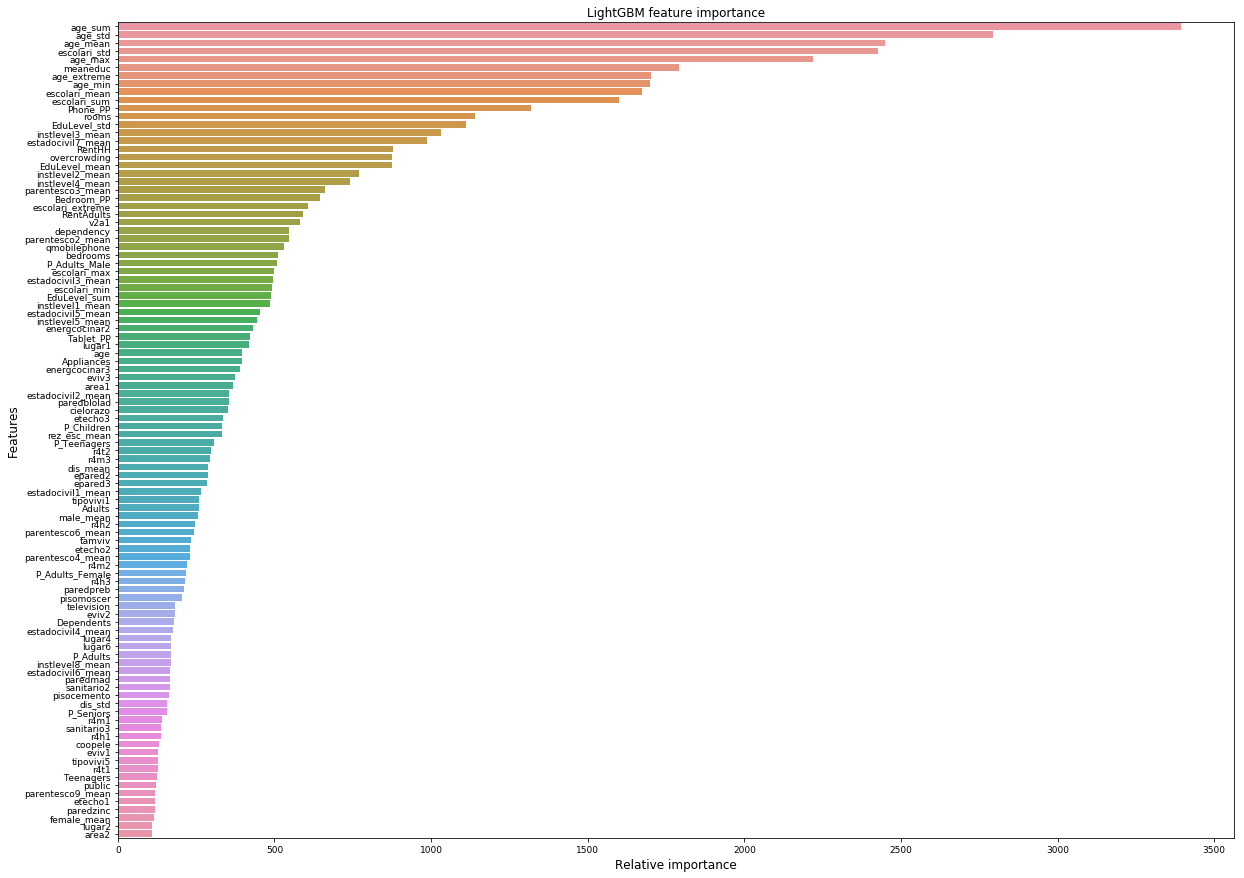

In [79]:
indices = np.argsort(clf.feature_importances_)[::-1]
top_100_indices = indices[:100]

# Visualise these with a barplot
plt.subplots(figsize=(20, 15))
g = sns.barplot(y=X.columns[top_100_indices], x = clf.feature_importances_[top_100_indices], orient='h')
g.set_xlabel("Relative importance",fontsize=12)
g.set_ylabel("Features",fontsize=12)
g.tick_params(labelsize=9)
g.set_title("LightGBM feature importance")

**From the plot above, we understand that the maximum and average age of individuals in a household, overcrowding, years of schooling, average education level and number of tablets own per person are among the most important features on predicting the poverty level of a household.**

# Feature Selection
**We will attempt to re-train the model by selecting the top 100 features based on the previously trained Light GBM model features importance output. The intuition is to remove variables that have very little influence in predicting the Target (poverty level) and give the model more focus on the important variables.**

In [81]:
X2 = X.iloc[:,top_100_indices]
Xtest2 = testML.copy().iloc[:,top_100_indices]


In [82]:
# Re-training on top 100 features
test_predictions = []
for train_index, val_index in kf.split(X2, y):
    print("=======")
    X_train, X_val = X2.iloc[train_index], X2.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric=evaluate_macroF1_lgb,
            early_stopping_rounds=400, verbose=100)
    test_predictions.append(clf.predict(Xtest2)) # store predictions on test set for Kaggle Submission


Training until validation scores don't improve for 400 rounds.
[100]	valid_0's multi_logloss: 0.428406	valid_0's macroF1: 0.862628
[200]	valid_0's multi_logloss: 0.26017	valid_0's macroF1: 0.924719
[300]	valid_0's multi_logloss: 0.183126	valid_0's macroF1: 0.942162
[400]	valid_0's multi_logloss: 0.150515	valid_0's macroF1: 0.952269
[500]	valid_0's multi_logloss: 0.144704	valid_0's macroF1: 0.954345
[600]	valid_0's multi_logloss: 0.148951	valid_0's macroF1: 0.955362
[700]	valid_0's multi_logloss: 0.157243	valid_0's macroF1: 0.954963
[800]	valid_0's multi_logloss: 0.169609	valid_0's macroF1: 0.956219
[900]	valid_0's multi_logloss: 0.184067	valid_0's macroF1: 0.957331
Early stopping, best iteration is:
[501]	valid_0's multi_logloss: 0.144523	valid_0's macroF1: 0.954256


LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=0.93, importance_type='split', learning_rate=0.1,
        max_depth=8, metric='multi_logloss', min_child_samples=95,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=5000,
        n_jobs=4, num_leaves=80, objective='multiclass', random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=0.96,
        subsample_for_bin=200000, subsample_freq=0)

C:\Users\jy\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 400 rounds.
[100]	valid_0's multi_logloss: 0.452837	valid_0's macroF1: 0.85762
[200]	valid_0's multi_logloss: 0.260423	valid_0's macroF1: 0.911271
[300]	valid_0's multi_logloss: 0.179353	valid_0's macroF1: 0.945103
[400]	valid_0's multi_logloss: 0.137801	valid_0's macroF1: 0.95341
[500]	valid_0's multi_logloss: 0.117944	valid_0's macroF1: 0.963627
[600]	valid_0's multi_logloss: 0.112991	valid_0's macroF1: 0.966261
[700]	valid_0's multi_logloss: 0.115669	valid_0's macroF1: 0.966859
[800]	valid_0's multi_logloss: 0.1231	valid_0's macroF1: 0.966859
[900]	valid_0's multi_logloss: 0.130956	valid_0's macroF1: 0.967066
[1000]	valid_0's multi_logloss: 0.140215	valid_0's macroF1: 0.967066
Early stopping, best iteration is:
[613]	valid_0's multi_logloss: 0.112341	valid_0's macroF1: 0.965775


LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=0.93, importance_type='split', learning_rate=0.1,
        max_depth=8, metric='multi_logloss', min_child_samples=95,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=5000,
        n_jobs=4, num_leaves=80, objective='multiclass', random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=0.96,
        subsample_for_bin=200000, subsample_freq=0)

C:\Users\jy\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 400 rounds.
[100]	valid_0's multi_logloss: 0.436781	valid_0's macroF1: 0.860327
[200]	valid_0's multi_logloss: 0.258214	valid_0's macroF1: 0.915963
[300]	valid_0's multi_logloss: 0.171368	valid_0's macroF1: 0.944206
[400]	valid_0's multi_logloss: 0.131644	valid_0's macroF1: 0.949909
[500]	valid_0's multi_logloss: 0.12272	valid_0's macroF1: 0.956074
[600]	valid_0's multi_logloss: 0.122662	valid_0's macroF1: 0.958233
[700]	valid_0's multi_logloss: 0.130592	valid_0's macroF1: 0.959899
[800]	valid_0's multi_logloss: 0.138716	valid_0's macroF1: 0.95848
[900]	valid_0's multi_logloss: 0.149065	valid_0's macroF1: 0.956163
Early stopping, best iteration is:
[576]	valid_0's multi_logloss: 0.12224	valid_0's macroF1: 0.957873


LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=0.93, importance_type='split', learning_rate=0.1,
        max_depth=8, metric='multi_logloss', min_child_samples=95,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=5000,
        n_jobs=4, num_leaves=80, objective='multiclass', random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=0.96,
        subsample_for_bin=200000, subsample_freq=0)

C:\Users\jy\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 400 rounds.
[100]	valid_0's multi_logloss: 0.436732	valid_0's macroF1: 0.859133
[200]	valid_0's multi_logloss: 0.247478	valid_0's macroF1: 0.922971
[300]	valid_0's multi_logloss: 0.162045	valid_0's macroF1: 0.948579
[400]	valid_0's multi_logloss: 0.121412	valid_0's macroF1: 0.95914
[500]	valid_0's multi_logloss: 0.105413	valid_0's macroF1: 0.963249
[600]	valid_0's multi_logloss: 0.103462	valid_0's macroF1: 0.962772
[700]	valid_0's multi_logloss: 0.107617	valid_0's macroF1: 0.962772
[800]	valid_0's multi_logloss: 0.115195	valid_0's macroF1: 0.963327
[900]	valid_0's multi_logloss: 0.125214	valid_0's macroF1: 0.963327
Early stopping, best iteration is:
[531]	valid_0's multi_logloss: 0.10311	valid_0's macroF1: 0.962772


LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=0.93, importance_type='split', learning_rate=0.1,
        max_depth=8, metric='multi_logloss', min_child_samples=95,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=5000,
        n_jobs=4, num_leaves=80, objective='multiclass', random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=0.96,
        subsample_for_bin=200000, subsample_freq=0)

C:\Users\jy\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 400 rounds.
[100]	valid_0's multi_logloss: 0.448952	valid_0's macroF1: 0.842949
[200]	valid_0's multi_logloss: 0.271632	valid_0's macroF1: 0.895983
[300]	valid_0's multi_logloss: 0.186447	valid_0's macroF1: 0.923895
[400]	valid_0's multi_logloss: 0.146759	valid_0's macroF1: 0.936756
[500]	valid_0's multi_logloss: 0.132076	valid_0's macroF1: 0.940976
[600]	valid_0's multi_logloss: 0.128427	valid_0's macroF1: 0.944787
[700]	valid_0's multi_logloss: 0.136617	valid_0's macroF1: 0.947216
[800]	valid_0's multi_logloss: 0.145365	valid_0's macroF1: 0.950257
[900]	valid_0's multi_logloss: 0.155459	valid_0's macroF1: 0.949013
Early stopping, best iteration is:
[589]	valid_0's multi_logloss: 0.127575	valid_0's macroF1: 0.943014


LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=0.93, importance_type='split', learning_rate=0.1,
        max_depth=8, metric='multi_logloss', min_child_samples=95,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=5000,
        n_jobs=4, num_leaves=80, objective='multiclass', random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=0.96,
        subsample_for_bin=200000, subsample_freq=0)

C:\Users\jy\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# Submission: Prediction on Test Data

**We take the mean of the predictions made by the 5 models we trained earlier using 5-fold Stratified cross validation.**

In [89]:
# Vote on the final target using Mean
submission['Target'] = np.array(test_predictions).mean(axis=0).round().astype(int)
submission['Target'].value_counts()
submission.head()

4    16111
2     3743
3     2999
1     1003
Name: Target, dtype: int64

,Id,Target
0,ID_2f6873615,4
1,ID_1c78846d2,4
2,ID_e5442cf6a,4
3,ID_a8db26a79,4
4,ID_a62966799,4


**We make another attempt by taking the mode of the predictions made by the 5 models we trained earlier using 5-fold Stratified cross validation.**

In [90]:
submission_mode = submission.copy()

# Vote on the final target using Mode
test_pred_df = pd.DataFrame(test_predictions)
voted_test_predictions = test_pred_df.T.mode(axis = 1).iloc[:,0].values

submission_mode['Target'] = np.array(voted_test_predictions).astype(int)
submission_mode['Target'].value_counts()
submission_mode.head()

4    16557
2     3981
3     2096
1     1222
Name: Target, dtype: int64

,Id,Target
0,ID_2f6873615,4
1,ID_1c78846d2,4
2,ID_e5442cf6a,4
3,ID_a8db26a79,4
4,ID_a62966799,4


**The DataFrame containing the Predictions on the Test Data is saved to a csv for submission in Kaggle.**  
*Competition Leaderboard: <https://www.kaggle.com/c/costa-rican-household-poverty-prediction/leaderboard>*

In [91]:
submission.to_csv('submission_lgb_5.csv',index=False)
submission_mode.to_csv('submission_lgb_6.csv',index=False)



In [ ]:
# Test Result:
